# Neural Network Quantum State



In [73]:
import os
import json
import time

import pandas as pd
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import flax
import flax.linen as nn
import netket as nk

from scipy.sparse.linalg import eigsh
from netket.operator.spin import sigmaz 
from tqdm.autonotebook import tqdm

In [74]:
os.environ["JAX_PLATFORM_NAME"] = "gpu" # or gpu

In [117]:
# Define a 1d chain
L = 15
g = nk.graph.Hypercube(length=L, n_dim=1, pbc=True)
N = g.n_nodes

In [118]:
# Define the Hilbert space based on this graph
# We impose to have a fixed total magnetization of zero 
hi = nk.hilbert.Spin(s=1, total_sz=0, N=N)

# Create the local sampler on the Hilbert space
sampler = nk.sampler.MetropolisLocal(hi)

In [119]:
# Write Hamiltonian
# TODO parameters for interaction strength?
H = sum(sigmaz(hi, i) * sigmaz(hi, j) for i, j in g.edges())
H += sum(1/3 * sigmaz(hi, i) * sigmaz(hi, j) * sigmaz(hi, i) * sigmaz(hi, j) for i, j in g.edges())

In [120]:
# Show as sparse normal matrix
sp_h=H.to_sparse()
display(sp_h.shape)

# and solve eigenvalues
eig_vals, eig_vecs = eigsh(sp_h, k=2, which="SA")
print("eigenvalues with scipy sparse:", eig_vals)

E_gs = eig_vals[0]

(1787607, 1787607)

eigenvalues with scipy sparse: [-1.33540399e-15  4.10372323e-15]


In [125]:
class FFN(nn.Module):
    
    # You can define attributes at the module-level
    # with a default. This allows you to easily change
    # some hyper-parameter without redefining the whole 
    # flax module.
    alpha : int = 1
            
    @nn.compact
    def __call__(self, x):

        # here we construct the first dense layer using a
        # pre-built implementation in flax.
        # features is the number of output nodes
        # WARNING: Won't work with complex hamiltonians because
        # of a bug in flax. Use nk.nn.Dense otherwise. 
        # dense = nn.Dense(features=self.alpha * x.shape[-1])
        
        x = x.reshape(-1, 1, x.shape[-1])
        dense = nk.nn.DenseSymm(symmetries=g.translation_group(),
                           features=self.alpha,
                           kernel_init=nn.initializers.normal(stddev=0.01))
        

        # Forward
        # we apply the dense layer to the input
        y = dense(x)

        # the non-linearity is a simple ReLu
        y = nn.relu(y)
                
        # sum the output
        return jnp.sum(y, axis=(-1,-2))


In [126]:
model = FFN(alpha=1)

vstate = nk.vqs.MCState(sampler, model, n_samples=1008)


vstate.n_parameters

16

In [127]:
optimizer = nk.optimizer.Adam(learning_rate=0.1)

# Notice the use, again of Stochastic Reconfiguration, which considerably improves the optimisation
gs = nk.driver.VMC(H, optimizer, variational_state=vstate,preconditioner=nk.optimizer.SR(diag_shift=0.1))

log=nk.logging.RuntimeLog()
gs.run(n_iter=300,out=log)

ffn_energy = vstate.expect(H)
error = abs((ffn_energy.mean-eig_vals[0])/eig_vals[0])
print("Optimized energy and relative error: ", ffn_energy, error)

100%|██████████| 300/300 [00:02<00:00, 101.38it/s, Energy=21.94 ± 0.23 [σ²=51.89, R̂=1.0138]]


Optimized energy and relative error:  22.10 ± 0.22 [σ²=50.95, R̂=1.0080] 1.6552666871558698e+16


Text(0, 0.5, 'Energy')

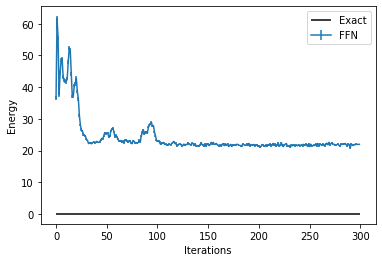

In [128]:
data_FFN = log.data

plt.errorbar(data_FFN["Energy"].iters, data_FFN["Energy"].Mean, yerr=data_FFN["Energy"].Sigma, label="FFN")
plt.hlines([E_gs], xmin=0, xmax=300, color='black', label="Exact")
plt.legend()

plt.xlabel('Iterations')
plt.ylabel('Energy')

In [109]:
# get quantum geometric tensor of state
qgt = vstate.quantum_geometric_tensor()
qgt

QGTOnTheFly(diag_shift=0.0)

In [116]:
QGT = qgt.to_dense()
jnp.real(QGT)

DeviceArray([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00],
             [-4.71844785e-16,  1.02597868e+00,  8.42072940e-03,
               1.02597868e+00,  8.42072940e-03,  1.02597868e+00,
               8.42072940e-03],
             [-6.14092110e-16,  8.42072940e-03,  7.84828515e-01,
               8.42072940e-03,  7.84828515e-01,  8.42072940e-03,
               7.84828515e-01],
             [-4.71844785e-16,  1.02597868e+00,  8.42072940e-03,
               1.02597868e+00,  8.42072940e-03,  1.02597868e+00,
               8.42072940e-03],
             [-6.14092110e-16,  8.42072940e-03,  7.84828515e-01,
               8.42072940e-03,  7.84828515e-01,  8.42072940e-03,
               7.84828515e-01],
             [-4.71844785e-16,  1.02597868e+00,  8.42072940e-03,
               1.02597868e+00,  8.42072940e-03,  1.02597868e+00,
               8.42072940e-03],
             [-6.14092110e-1